# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 20, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 20, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9572
Epoch 1/200, Iteration 2/12, Loss: 0.9355
Epoch 1/200, Iteration 3/12, Loss: 0.7453
Epoch 1/200, Iteration 4/12, Loss: 0.9020
Epoch 1/200, Iteration 5/12, Loss: 0.8784
Epoch 1/200, Iteration 6/12, Loss: 0.6916
Epoch 1/200, Iteration 7/12, Loss: 0.6398
Epoch 1/200, Iteration 8/12, Loss: 0.5379
Epoch 1/200, Iteration 9/12, Loss: 0.4617
Epoch 1/200, Iteration 10/12, Loss: 0.3935
Epoch 1/200, Iteration 11/12, Loss: 0.4946
Epoch 1/200, Iteration 12/12, Loss: 0.4671
Epoch 1/200, Iteration 13/12, Loss: 0.2958
Train Error: 
 Accuracy: 72.0%, Avg loss: 0.380080, MRE: 0.363751, MAE: 0.065478 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.413881, MRE: 0.275339, MAE: 0.066968 

Epoch 2/200, Iteration 1/12, Loss: 0.4520
Epoch 2/200, Iteration 2/12, Loss: 0.3276
Epoch 2/200, Iteration 3/12, Loss: 0.2943
Epoch 2/200, Iteration 4/12, Loss: 0.1751
Epoch 2/200, Iteration 5/12, Loss: 0.1937
Epoch 2/200, Iteration 6/12, Loss: 0.2393
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.004111, MRE: 0.032117, MAE: 0.005345 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004175, MRE: 0.028397, MAE: 0.005768 

Epoch 13/200, Iteration 1/12, Loss: 0.0055
Epoch 13/200, Iteration 2/12, Loss: 0.0050
Epoch 13/200, Iteration 3/12, Loss: 0.0031
Epoch 13/200, Iteration 4/12, Loss: 0.0026
Epoch 13/200, Iteration 5/12, Loss: 0.0035
Epoch 13/200, Iteration 6/12, Loss: 0.0034
Epoch 13/200, Iteration 7/12, Loss: 0.0039
Epoch 13/200, Iteration 8/12, Loss: 0.0039
Epoch 13/200, Iteration 9/12, Loss: 0.0031
Epoch 13/200, Iteration 10/12, Loss: 0.0025
Epoch 13/200, Iteration 11/12, Loss: 0.0051
Epoch 13/200, Iteration 12/12, Loss: 0.0064
Epoch 13/200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.003116, MRE: 0.028760, MAE: 0.004452 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001978, MRE: 0.022652, MAE: 0.004393 

Epoch 14/200, Iteration 1/12, Loss: 0.0045
Epoch 14/200, Iteration 2/12, Loss: 0.0020
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.001027, MRE: 0.024188, MAE: 0.002925 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001021, MRE: 0.017242, MAE: 0.002876 

Epoch 25/200, Iteration 1/12, Loss: 0.0011
Epoch 25/200, Iteration 2/12, Loss: 0.0009
Epoch 25/200, Iteration 3/12, Loss: 0.0009
Epoch 25/200, Iteration 4/12, Loss: 0.0013
Epoch 25/200, Iteration 5/12, Loss: 0.0007
Epoch 25/200, Iteration 6/12, Loss: 0.0015
Epoch 25/200, Iteration 7/12, Loss: 0.0013
Epoch 25/200, Iteration 8/12, Loss: 0.0014
Epoch 25/200, Iteration 9/12, Loss: 0.0009
Epoch 25/200, Iteration 10/12, Loss: 0.0012
Epoch 25/200, Iteration 11/12, Loss: 0.0023
Epoch 25/200, Iteration 12/12, Loss: 0.0008
Epoch 25/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.001391, MRE: 0.024429, MAE: 0.003402 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001321, MRE: 0.018486, MAE: 0.003305 

Epoch 26/200, Iteration 1/12, Loss: 0.0014
Epoch 26/200, Iteration 2/12, Loss: 0.0007
Epoch 26/200, Iterat

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000574, MRE: 0.015994, MAE: 0.002136 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000417, MRE: 0.010758, MAE: 0.001989 

Epoch 37/200, Iteration 1/12, Loss: 0.0006
Epoch 37/200, Iteration 2/12, Loss: 0.0005
Epoch 37/200, Iteration 3/12, Loss: 0.0006
Epoch 37/200, Iteration 4/12, Loss: 0.0007
Epoch 37/200, Iteration 5/12, Loss: 0.0007
Epoch 37/200, Iteration 6/12, Loss: 0.0005
Epoch 37/200, Iteration 7/12, Loss: 0.0007
Epoch 37/200, Iteration 8/12, Loss: 0.0006
Epoch 37/200, Iteration 9/12, Loss: 0.0005
Epoch 37/200, Iteration 10/12, Loss: 0.0005
Epoch 37/200, Iteration 11/12, Loss: 0.0005
Epoch 37/200, Iteration 12/12, Loss: 0.0005
Epoch 37/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000446, MRE: 0.015592, MAE: 0.002072 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000427, MRE: 0.010257, MAE: 0.001978 

Epoch 38/200, Iteration 1/12, Loss: 0.0005
Epoch 38/200, Iteration 2/12, Loss: 0.0003
Epoch 38/200, Itera

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000432, MRE: 0.008905, MAE: 0.001886 

Epoch 49/200, Iteration 1/12, Loss: 0.0004
Epoch 49/200, Iteration 2/12, Loss: 0.0005
Epoch 49/200, Iteration 3/12, Loss: 0.0008
Epoch 49/200, Iteration 4/12, Loss: 0.0006
Epoch 49/200, Iteration 5/12, Loss: 0.0005
Epoch 49/200, Iteration 6/12, Loss: 0.0005
Epoch 49/200, Iteration 7/12, Loss: 0.0006
Epoch 49/200, Iteration 8/12, Loss: 0.0003
Epoch 49/200, Iteration 9/12, Loss: 0.0004
Epoch 49/200, Iteration 10/12, Loss: 0.0004
Epoch 49/200, Iteration 11/12, Loss: 0.0004
Epoch 49/200, Iteration 12/12, Loss: 0.0004
Epoch 49/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000450, MRE: 0.014961, MAE: 0.002109 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000382, MRE: 0.010205, MAE: 0.001950 

Epoch 50/200, Iteration 1/12, Loss: 0.0004
Epoch 50/200, Iteration 2/12, Loss: 0.0005
Epoch 50/200, Iteration 3/12, Loss: 0.0005
Epoch 50/200, Iteration 4/12, Loss: 0.0005
Epoch 50/200, I

Epoch 61/200, Iteration 10/12, Loss: 0.0003
Epoch 61/200, Iteration 11/12, Loss: 0.0004
Epoch 61/200, Iteration 12/12, Loss: 0.0005
Epoch 61/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000358, MRE: 0.012745, MAE: 0.001841 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000319, MRE: 0.008208, MAE: 0.001763 

Epoch 62/200, Iteration 1/12, Loss: 0.0003
Epoch 62/200, Iteration 2/12, Loss: 0.0006
Epoch 62/200, Iteration 3/12, Loss: 0.0004
Epoch 62/200, Iteration 4/12, Loss: 0.0002
Epoch 62/200, Iteration 5/12, Loss: 0.0008
Epoch 62/200, Iteration 6/12, Loss: 0.0004
Epoch 62/200, Iteration 7/12, Loss: 0.0004
Epoch 62/200, Iteration 8/12, Loss: 0.0006
Epoch 62/200, Iteration 9/12, Loss: 0.0009
Epoch 62/200, Iteration 10/12, Loss: 0.0010
Epoch 62/200, Iteration 11/12, Loss: 0.0009
Epoch 62/200, Iteration 12/12, Loss: 0.0003
Epoch 62/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001099, MRE: 0.018881, MAE: 0.003339 

Test Error

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000325, MRE: 0.011214, MAE: 0.001658 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000237, MRE: 0.007843, MAE: 0.001535 

Epoch 73/200, Iteration 1/12, Loss: 0.0003
Epoch 73/200, Iteration 2/12, Loss: 0.0003
Epoch 73/200, Iteration 3/12, Loss: 0.0002
Epoch 73/200, Iteration 4/12, Loss: 0.0002
Epoch 73/200, Iteration 5/12, Loss: 0.0003
Epoch 73/200, Iteration 6/12, Loss: 0.0002
Epoch 73/200, Iteration 7/12, Loss: 0.0003
Epoch 73/200, Iteration 8/12, Loss: 0.0003
Epoch 73/200, Iteration 9/12, Loss: 0.0003
Epoch 73/200, Iteration 10/12, Loss: 0.0002
Epoch 73/200, Iteration 11/12, Loss: 0.0002
Epoch 73/200, Iteration 12/12, Loss: 0.0002
Epoch 73/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000291, MRE: 0.013036, MAE: 0.001602 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000313, MRE: 0.009376, MAE: 0.001599 

Epoch 74/200, Iteration 1/12, Loss: 0.0003
Epoch 74/200, Iteration 2/12, Loss: 0.0002
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.009560, MAE: 0.001150 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.006080, MAE: 0.001184 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0002
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0002
Epoch 85/200, Iteration 6/12, Loss: 0.0001
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0003
Epoch 85/200, Iteration 9/12, Loss: 0.0002
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0001
Epoch 85/200, Iteration 12/12, Loss: 0.0001
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.009578, MAE: 0.001126 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.006188, MAE: 0.001189 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000125, MRE: 0.009153, MAE: 0.001073 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.006030, MAE: 0.001154 

Epoch 97/200, Iteration 1/12, Loss: 0.0001
Epoch 97/200, Iteration 2/12, Loss: 0.0001
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0001
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0001
Epoch 97/200, Iteration 8/12, Loss: 0.0001
Epoch 97/200, Iteration 9/12, Loss: 0.0001
Epoch 97/200, Iteration 10/12, Loss: 0.0002
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0001
Epoch 97/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.009383, MAE: 0.001090 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000127, MRE: 0.005892, MAE: 0.001125 

Epoch 98/200, Iteration 1/12, Loss: 0.0001
Epoch 98/200, Iteration 2/12, Loss: 0.0001
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.009214, MAE: 0.001087 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000125, MRE: 0.005773, MAE: 0.001118 

Epoch 109/200, Iteration 1/12, Loss: 0.0001
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Epoch 109/200, Iteration 3/12, Loss: 0.0001
Epoch 109/200, Iteration 4/12, Loss: 0.0001
Epoch 109/200, Iteration 5/12, Loss: 0.0001
Epoch 109/200, Iteration 6/12, Loss: 0.0001
Epoch 109/200, Iteration 7/12, Loss: 0.0001
Epoch 109/200, Iteration 8/12, Loss: 0.0002
Epoch 109/200, Iteration 9/12, Loss: 0.0001
Epoch 109/200, Iteration 10/12, Loss: 0.0002
Epoch 109/200, Iteration 11/12, Loss: 0.0001
Epoch 109/200, Iteration 12/12, Loss: 0.0002
Epoch 109/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000127, MRE: 0.009066, MAE: 0.001076 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.005855, MAE: 0.001118 

Epoch 110/200, Iteration 1/12, Loss: 0.0001
Epoch 110/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000119, MRE: 0.008838, MAE: 0.001042 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000128, MRE: 0.005736, MAE: 0.001111 

Epoch 122/200, Iteration 1/12, Loss: 0.0001
Epoch 122/200, Iteration 2/12, Loss: 0.0001
Epoch 122/200, Iteration 3/12, Loss: 0.0001
Epoch 122/200, Iteration 4/12, Loss: 0.0001
Epoch 122/200, Iteration 5/12, Loss: 0.0001
Epoch 122/200, Iteration 6/12, Loss: 0.0001
Epoch 122/200, Iteration 7/12, Loss: 0.0001
Epoch 122/200, Iteration 8/12, Loss: 0.0001
Epoch 122/200, Iteration 9/12, Loss: 0.0002
Epoch 122/200, Iteration 10/12, Loss: 0.0001
Epoch 122/200, Iteration 11/12, Loss: 0.0002
Epoch 122/200, Iteration 12/12, Loss: 0.0001
Epoch 122/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.008905, MAE: 0.001040 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000121, MRE: 0.005788, MAE: 0.001117 

Epoch 123/200, Iteration 1/12, Loss: 0.0001
Epoch 123/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000128, MRE: 0.008794, MAE: 0.001070 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000135, MRE: 0.005786, MAE: 0.001123 

Epoch 134/200, Iteration 1/12, Loss: 0.0002
Epoch 134/200, Iteration 2/12, Loss: 0.0002
Epoch 134/200, Iteration 3/12, Loss: 0.0001
Epoch 134/200, Iteration 4/12, Loss: 0.0001
Epoch 134/200, Iteration 5/12, Loss: 0.0001
Epoch 134/200, Iteration 6/12, Loss: 0.0001
Epoch 134/200, Iteration 7/12, Loss: 0.0001
Epoch 134/200, Iteration 8/12, Loss: 0.0002
Epoch 134/200, Iteration 9/12, Loss: 0.0001
Epoch 134/200, Iteration 10/12, Loss: 0.0001
Epoch 134/200, Iteration 11/12, Loss: 0.0001
Epoch 134/200, Iteration 12/12, Loss: 0.0001
Epoch 134/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000135, MRE: 0.008915, MAE: 0.001086 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000152, MRE: 0.006358, MAE: 0.001205 

Epoch 135/200, Iteration 1/12, Loss: 0.0001
Epoch 135/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000123, MRE: 0.008959, MAE: 0.001066 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.005732, MAE: 0.001124 

Epoch 146/200, Iteration 1/12, Loss: 0.0001
Epoch 146/200, Iteration 2/12, Loss: 0.0001
Epoch 146/200, Iteration 3/12, Loss: 0.0001
Epoch 146/200, Iteration 4/12, Loss: 0.0002
Epoch 146/200, Iteration 5/12, Loss: 0.0001
Epoch 146/200, Iteration 6/12, Loss: 0.0001
Epoch 146/200, Iteration 7/12, Loss: 0.0002
Epoch 146/200, Iteration 8/12, Loss: 0.0001
Epoch 146/200, Iteration 9/12, Loss: 0.0001
Epoch 146/200, Iteration 10/12, Loss: 0.0001
Epoch 146/200, Iteration 11/12, Loss: 0.0001
Epoch 146/200, Iteration 12/12, Loss: 0.0001
Epoch 146/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.008434, MAE: 0.001012 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000122, MRE: 0.005619, MAE: 0.001088 

Epoch 147/200, Iteration 1/12, Loss: 0.0001
Epoch 147/200, Iteration 2/12, Loss: 0.0003
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.008410, MAE: 0.000997 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.005471, MAE: 0.001067 

Epoch 158/200, Iteration 1/12, Loss: 0.0001
Epoch 158/200, Iteration 2/12, Loss: 0.0002
Epoch 158/200, Iteration 3/12, Loss: 0.0001
Epoch 158/200, Iteration 4/12, Loss: 0.0001
Epoch 158/200, Iteration 5/12, Loss: 0.0001
Epoch 158/200, Iteration 6/12, Loss: 0.0001
Epoch 158/200, Iteration 7/12, Loss: 0.0001
Epoch 158/200, Iteration 8/12, Loss: 0.0002
Epoch 158/200, Iteration 9/12, Loss: 0.0001
Epoch 158/200, Iteration 10/12, Loss: 0.0001
Epoch 158/200, Iteration 11/12, Loss: 0.0001
Epoch 158/200, Iteration 12/12, Loss: 0.0001
Epoch 158/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.008563, MAE: 0.001001 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000121, MRE: 0.005605, MAE: 0.001084 

Epoch 159/200, Iteration 1/12, Loss: 0.0001
Epoch 159/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000102, MRE: 0.008275, MAE: 0.000969 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.005395, MAE: 0.001047 

Epoch 170/200, Iteration 1/12, Loss: 0.0001
Epoch 170/200, Iteration 2/12, Loss: 0.0001
Epoch 170/200, Iteration 3/12, Loss: 0.0001
Epoch 170/200, Iteration 4/12, Loss: 0.0001
Epoch 170/200, Iteration 5/12, Loss: 0.0001
Epoch 170/200, Iteration 6/12, Loss: 0.0002
Epoch 170/200, Iteration 7/12, Loss: 0.0001
Epoch 170/200, Iteration 8/12, Loss: 0.0001
Epoch 170/200, Iteration 9/12, Loss: 0.0001
Epoch 170/200, Iteration 10/12, Loss: 0.0001
Epoch 170/200, Iteration 11/12, Loss: 0.0001
Epoch 170/200, Iteration 12/12, Loss: 0.0001
Epoch 170/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000102, MRE: 0.008336, MAE: 0.000970 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.005412, MAE: 0.001048 

Epoch 171/200, Iteration 1/12, Loss: 0.0001
Epoch 171/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000101, MRE: 0.008276, MAE: 0.000965 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.005401, MAE: 0.001044 

Epoch 183/200, Iteration 1/12, Loss: 0.0002
Epoch 183/200, Iteration 2/12, Loss: 0.0001
Epoch 183/200, Iteration 3/12, Loss: 0.0001
Epoch 183/200, Iteration 4/12, Loss: 0.0001
Epoch 183/200, Iteration 5/12, Loss: 0.0001
Epoch 183/200, Iteration 6/12, Loss: 0.0001
Epoch 183/200, Iteration 7/12, Loss: 0.0001
Epoch 183/200, Iteration 8/12, Loss: 0.0001
Epoch 183/200, Iteration 9/12, Loss: 0.0001
Epoch 183/200, Iteration 10/12, Loss: 0.0002
Epoch 183/200, Iteration 11/12, Loss: 0.0001
Epoch 183/200, Iteration 12/12, Loss: 0.0001
Epoch 183/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000102, MRE: 0.008266, MAE: 0.000969 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.005400, MAE: 0.001046 

Epoch 184/200, Iteration 1/12, Loss: 0.0001
Epoch 184/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000101, MRE: 0.008317, MAE: 0.000968 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.005383, MAE: 0.001043 

Epoch 195/200, Iteration 1/12, Loss: 0.0001
Epoch 195/200, Iteration 2/12, Loss: 0.0001
Epoch 195/200, Iteration 3/12, Loss: 0.0001
Epoch 195/200, Iteration 4/12, Loss: 0.0002
Epoch 195/200, Iteration 5/12, Loss: 0.0001
Epoch 195/200, Iteration 6/12, Loss: 0.0001
Epoch 195/200, Iteration 7/12, Loss: 0.0001
Epoch 195/200, Iteration 8/12, Loss: 0.0001
Epoch 195/200, Iteration 9/12, Loss: 0.0001
Epoch 195/200, Iteration 10/12, Loss: 0.0001
Epoch 195/200, Iteration 11/12, Loss: 0.0001
Epoch 195/200, Iteration 12/12, Loss: 0.0001
Epoch 195/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000101, MRE: 0.008258, MAE: 0.000958 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.005379, MAE: 0.001043 

Epoch 196/200, Iteration 1/12, Loss: 0.0001
Epoch 196/200, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

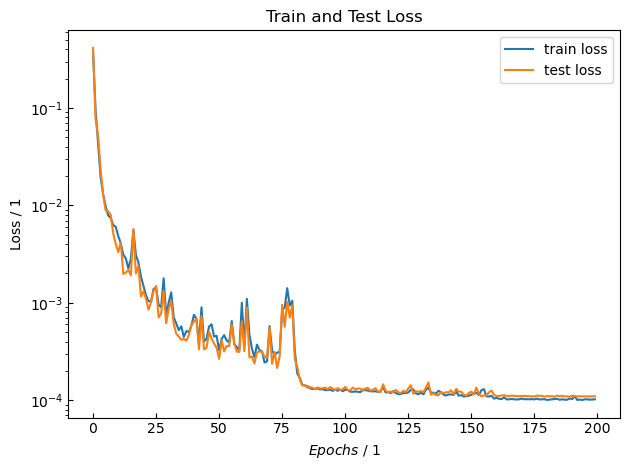

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999154922233164 , R^2(NH3) = 0.9998801166105327
Test Dataset: R^2(H2) = 0.9999095712021269 , R^2(NH3) = 0.9998861339650637
Max Error Training: |x_H2 - x_H2,pred| = 0.01573365010865968 , |x_NH3 - x_NH3,pred| = 0.006166057341366132
Max Error Test: |x_H2 - x_H2,pred| = 0.005302441710614503 , |x_NH3 - x_NH3,pred| = 0.005143193064521295


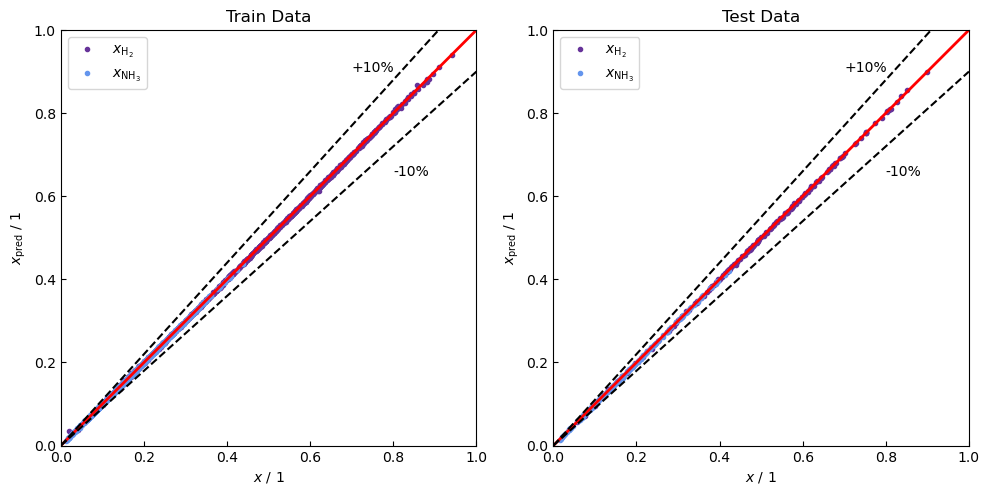

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

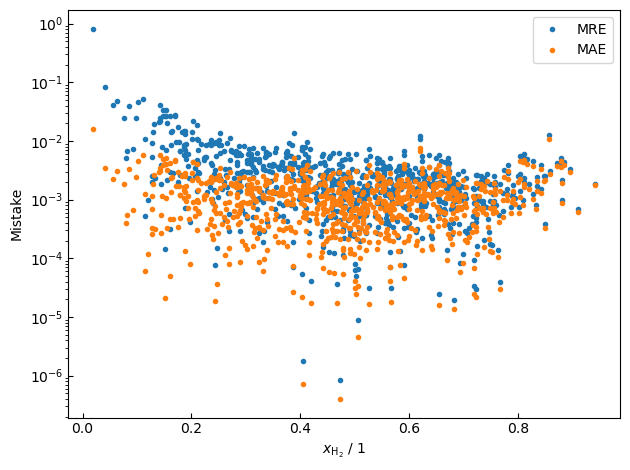

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

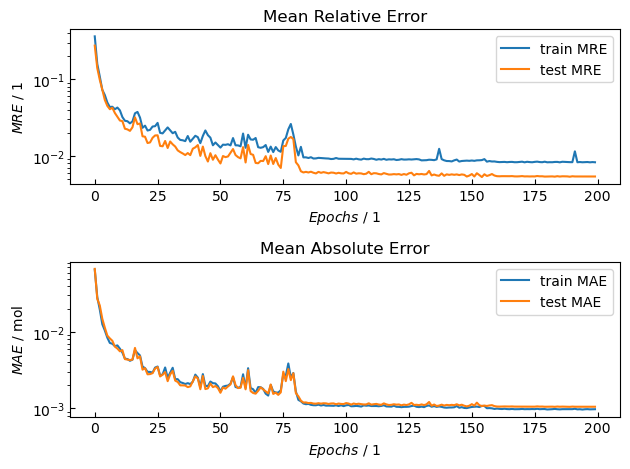

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

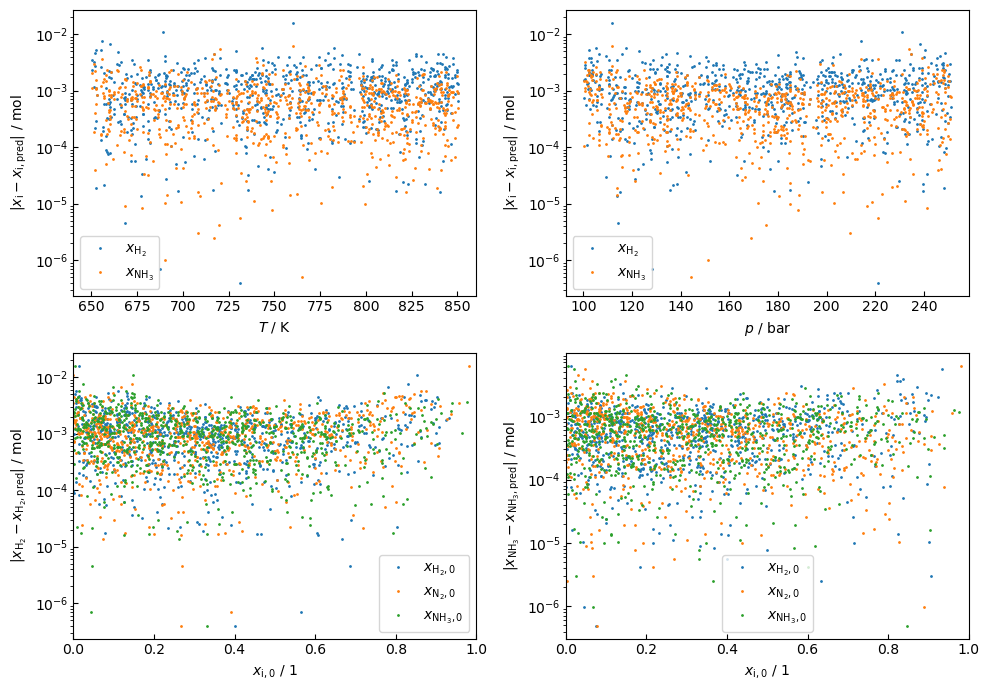

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

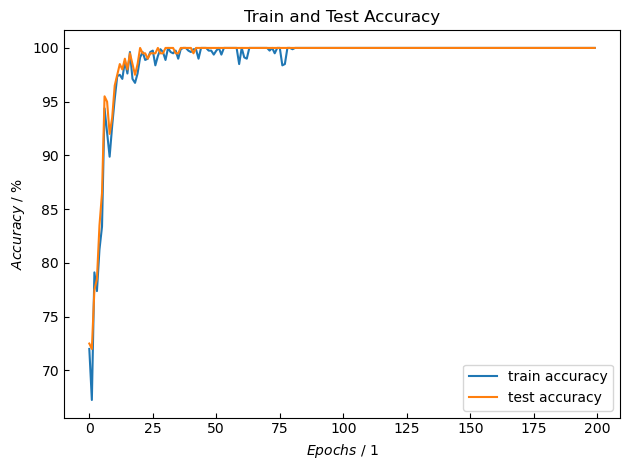

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 5.0043e-01, -7.9038e-01,  6.8017e-02,  2.2178e-02, -8.9418e-02],
        [ 1.5129e+00, -1.0347e+00, -3.4243e-01,  6.6872e-02,  2.6770e-01],
        [-8.6265e-01,  4.5460e-01, -1.2893e+00,  4.2004e-01,  8.3602e-01],
        [-2.0754e-01, -1.6050e+00, -1.4096e+00,  2.1889e+00, -8.5389e-01],
        [ 8.0536e-01,  5.5424e-01, -4.2203e-01,  4.0708e-01, -1.8868e-03],
        [ 1.1453e+00, -1.0705e+00, -3.2561e-01,  1.2234e+00, -9.3086e-01],
        [ 1.4172e-01,  2.2994e-01,  1.0731e+00, -7.9201e-01, -2.4361e-01],
        [ 7.4539e-01,  1.6291e+00,  1.4267e-01,  1.0845e+00, -1.2484e+00],
        [-7.5285e-02,  1.1237e+00,  1.7720e+00, -9.2834e-01, -7.9016e-01],
        [ 1.1586e+00, -7.6415e-01,  1.7384e-02,  4.2983e-01, -4.5638e-01],
        [-6.6966e-01,  9.3490e-01, -9.2039e-01,  7.0648e-01,  1.8117e-01],
        [ 7.3658e-01, -1.5913e+00,  1.1921e+00, -5.1824e-01, -6.4022e-01],
        [-8.3518e-01,  1.7761e-01, -1.7933e-01, -5.1011e-01,  6.9737e-01],
        [-4.4500e-01, -3.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.3527,  0.0639, -0.2935,  0.2214, -0.1009],
         [ 0.1070, -0.0274, -0.2991,  0.1250, -0.0372],
         [-0.4428,  0.2330, -0.3618,  0.2171, -0.0592],
         [-0.4065,  0.1866,  0.2141, -0.1651,  0.3333],
         [ 0.1911, -0.1066, -0.0172,  0.3835,  0.3759],
         [ 0.2719, -0.0090,  0.2982, -0.5575,  0.0302],
         [ 0.1646, -0.0710,  0.4893, -0.1369, -0.0213],
         [ 0.4984, -0.4518, -0.2104, -0.3047, -0.2239],
         [-0.2993, -0.1091, -0.4997,  0.4140, -0.4758],
         [ 0.0946, -0.1377,  0.3009, -0.0526, -0.3096],
         [ 0.2262, -0.2885, -0.0644, -0.4128, -0.0969],
         [ 0.5224, -0.0757,  0.3499, -0.1335,  0.1503],
         [ 0.1158,  0.2826, -0.2698,  0.4754,  0.0759],
         [ 0.0961, -0.0099, -0.0058,  0.1875, -0.3849],
         [ 0.1172,  0.0379, -0.0534,  0.2542, -0.3320],
         [-0.6021,  0.0837,  0.2056, -0.0155,  0.0386],
         [-0.3524, -0.0413,  0.3125, -0.0558,  0.2723],
         [ 0.0573, -0.162

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1850, 0.8475, 0.8354, 0.3993, 0.2445],
        [0.5159, 0.7048, 0.2523, 0.4991, 0.5905]])
tensor([[0.2387, 0.4686],
        [0.1673, 0.0315]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.2444e+00, -1.6702e+00, -9.6640e-01,  1.3150e+00, -3.9564e-01],
        [-7.4248e-01, -1.0883e+00,  6.1900e-02,  7.9642e-01, -8.7475e-01],
        [ 6.5412e-01,  1.6440e+00, -1.2710e+00,  8.1835e-01,  4.1093e-01],
        [ 7.6037e-01,  1.4890e-01,  1.3659e+00, -2.1920e-01, -1.1164e+00],
        [-1.3782e+00,  9.6939e-02, -7.1425e-01,  6.9541e-01, -9.8083e-03],
        [ 1.6075e+00,  2.1464e-01,  2.1559e+00, -1.1131e+00, -9.7814e-01],
        [ 7.5846e-01,  4.7586e-01,  1.0682e+00, -7.9016e-01, -2.4074e-01],
        [-1.4028e+00, -7.5049e-01,  1.4111e+00, -6.2756e-01, -7.4338e-01],
        [ 1.4926e+00, -6.4122e-01, -3.3851e-01, -1.5372e-01,  4.8932e-01],
        [ 4.4469e-01, -1.3178e+00, -5.7149e-01,  5.5093e-01, -2.2314e-03],
        [ 9.6685e-01,  9.9965e-01, -9.6235e-01,  1.2064e+00, -2.8858e-01],
        [ 1.4046e+00,  6.3450e-01, -1.1961e+00,  1.7900e+00, -6.5569e-01],
        [ 5.5695e-01,  1.4321e-01,  1.0718e+00,  2.3066e-01, -1.2876e+00],
        [-1.2533e+00, -7.

#### Histogramme Verteilung von $xi$ und $x{_i}$

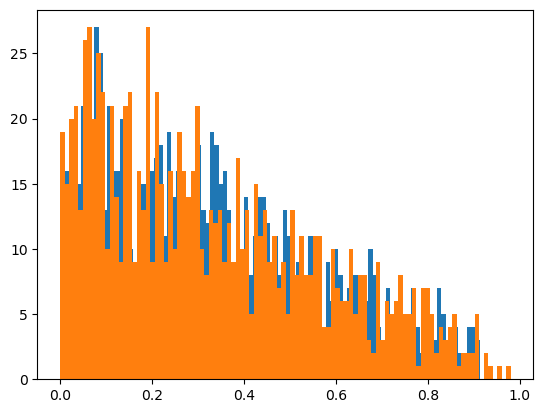

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_035.pth')
# np.savez('data/models/params_005_035.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)